## Setup

Import TensorFlow 2.0:

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt

## Exercise on in-graph training loop

This exercise teaches how to train a Keras model on the `horses_or_humans` dataset with the entire training process—loading batches, calculating gradients, updating parameters, calculating validation accuracy, and repeating until convergence— performed in-graph.

### Prepare the dataset

In [4]:
splits, info = tfds.load('horses_or_humans', as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'], data_dir='../data')

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [5]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [6]:
def set_image_size(size):
    image_size = size
    return image_size

In [7]:
# Create a autograph pre-processing function to resize and normalize an image
### START CODE HERE ###
@tf.function
def map_fn(img, label):
    image_size = set_image_size(224) # @REPLACE image_size = set_image_size(224)
    # resize the image
    img = tf.image.resize(img, (image_size, image_size))
    # normalize the image
    img /= 255.0
### END CODE HERE
    return img, label

In [8]:
# Prepare train dataset by using preprocessing with map_fn, shuffling and batching
def prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, batch_size):
    ### START CODE HERE ###
    train_ds = train_examples.map(map_fn).shuffle(buffer_size=num_examples).batch(batch_size)
    ### END CODE HERE ###
    valid_ds = validation_examples.map(map_fn).batch(batch_size)
    test_ds = test_examples.map(map_fn).batch(batch_size)
    
    return train_ds, valid_ds, test_ds

In [9]:
train_ds, valid_ds, test_ds = prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, BATCH_SIZE)

### Define the model

In [11]:
MODULE_HANDLE = '../data/resnet_50_feature_vector'
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,565,250
Trainable params: 4,098
Non-trainable params: 23,561,152
_________________________________________________________________


## Define optimizer, loss and metrics

In [12]:
def set_adam_optimizer():
    ### START CODE HERE ###
    # Define the adam optimizer
    optimizer = tf.keras.optimizers.Adam()
    ### END CODE HERE ###
    return optimizer

In [13]:
def set_sparse_cat_crossentropy_loss():
    ### START CODE HERE ###
    # Define object oriented metric of Sparse categorical crossentropy for train and val loss
    train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    val_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    ### END CODE HERE ###
    return train_loss, val_loss

In [14]:
def set_sparse_cat_crossentropy_accuracy():
    ### START CODE HERE ###
    # Define object oriented metric of Sparse categorical accuracy for train and val accuracy
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    ### END CODE HERE ###
    return train_accuracy, val_accuracy

In [15]:
optimizer = set_adam_optimizer()
train_loss, val_loss = set_sparse_cat_crossentropy_loss()
train_accuracy, val_accuracy = set_sparse_cat_crossentropy_accuracy()

### Define the training loop

In [16]:
device = '/gpu:0' if tf.test.is_gpu_available() else '/cpu:0'

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [17]:
EPOCHS = 2

In [18]:
# Custom training step
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
    ### START CODE HERE ###
        # Run the model on input x to get predictions
        predictions = model(x)
        # Compute the training loss using `train_loss` 
        loss = train_loss(y, predictions)

    # Using the tape and loss, compute the gradients on model variables
    grads = tape.gradient(loss, model.trainable_variables)
    
    # Zip the gradients and model variables, and then apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Call the train accuracy object on ground truth and predictions
    train_accuracy(y, predictions)
    ### END CODE HERE
    return loss

In [19]:
# Decorate this function with tf.function to enable autograph on the training loop
@tf.function
def train(model, optimizer, epochs, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            step += 1
            with tf.device(device_name=device):
                ### START CODE HERE ###
                # Run one training step by passing appropriate model parameters
                # required by the function and finally get the loss to report the results
                loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)
            # Rely on reliable debugging functions like tf.print to report your results.
            # Print the training step number, loss and accuracy
            tf.print('Step', step, # @REPLACE             None('Step', None,
                   ': train loss', loss, # @REPLACE                    ': train loss', None,
                   '; train accuracy', train_accuracy.result()) # @REPLACE                    '; train accuracy', None)
            ### END CODE HERE ###

        with tf.device(device_name=device):
            for x, y in valid_ds:
                # Call the model on the batches of inputs x and get the predictions
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)
        
        ### START CODE HERE ###
        # Print the validation loss and accuracy
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result()) # @REPLACE        None('val loss', None, '; val accuracy', None)
        ### END CODE HERE

In [20]:
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy)

Step 1 : train loss 0.650058508 ; train accuracy 0.59375
Step 2 : train loss 0.524560571 ; train accuracy 0.671875
Step 3 : train loss 0.257832378 ; train accuracy 0.760416687
Step 4 : train loss 0.191015288 ; train accuracy 0.8203125
Step 5 : train loss 0.078950271 ; train accuracy 0.85625
Step 6 : train loss 0.18720448 ; train accuracy 0.869791687
Step 7 : train loss 0.0538512617 ; train accuracy 0.888392866
Step 8 : train loss 0.0552151799 ; train accuracy 0.90234375
Step 9 : train loss 0.0275174584 ; train accuracy 0.913194418
Step 10 : train loss 0.0207720213 ; train accuracy 0.921875
Step 11 : train loss 0.0190020632 ; train accuracy 0.928977251
Step 12 : train loss 0.0293630157 ; train accuracy 0.934895813
Step 13 : train loss 0.0307099707 ; train accuracy 0.939903855
Step 14 : train loss 0.0129034184 ; train accuracy 0.944196403
Step 15 : train loss 0.0147371348 ; train accuracy 0.947916687
Step 16 : train loss 0.0141655598 ; train accuracy 0.951171875
Step 17 : train loss 0.00

# Evaluation

In [21]:
test_imgs = []
test_labels = []

predictions = []
with tf.device(device_name=device):
    for images, labels in test_ds:
        preds = model(images)
        preds = preds.numpy()
        predictions.extend(preds)

        test_imgs.extend(images.numpy())
        test_labels.extend(labels.numpy())

In [22]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['horse', 'human']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    print(true_label)
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)



0


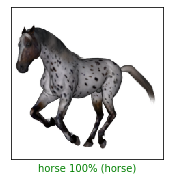

In [23]:
#@title Visualize the outputs { run: "auto" }
index = 8 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()